In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
import dill
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

In [2]:
df = pd.read_csv('../Data/cleaned_data.csv', low_memory = False)
date_cols = ["EOMDate", "EOMOpenDt_YrMo", "EOMCloseDt_YrMo", "EOMMaturityDt_YrMo", "EOMDefaultDt_YrMO"]

In [3]:
df["Balance_Ratio"] = df['Unpaid_Balance_Amt'] / df['OpenAmt_YrMo']
df['Balance_Ratio'] = np.where(df.OpenAmt_YrMo == 0, df.Unpaid_Balance_Amt.astype(bool).astype(int), df['Balance_Ratio'])
df['Balance_Ratio'] = df['Balance_Ratio'].clip(0, 1)

In [4]:
X, y = df.drop(columns = ['AcctID', 'From_RiskCd', 'To_RiskCd', 'From_Risk_Group', 'To_Risk_Group', 'CAConcentrationTyDe', 
                       'SECSegmentDe_YrMo', 'RevolveIn', 'Default_Flag', 'Closed_Flag', 'Prepay_Flag', 'Balance_Ratio'
                    ] + date_cols), df['Balance_Ratio']

In [5]:
X['PmtModeTyDe'] = (X['PmtModeTyDe'] == 'Int Only').replace({0: 'Int and Principal', 1: 'Int Only'})
X['SICIndustryMapDe'] = X.SICIndustryMapDe.str.replace("\-.*","", regex = True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = pd.cut(y, [-1, 0, .9999999, 1]), random_state = 1234)

In [7]:
class CustomPipeline(Pipeline):
    def __init__(self, steps, memory = None, verbose = False):
        super().__init__(steps, memory = memory, verbose = verbose)
    
    def set_output_activation(self, out_activation = "logistic"):
        self.named_steps['Model'].out_activation_ = out_activation
        
    def partial_fit(self, X, y):
        try:
            X = self.named_steps['ColumnTransformer'].transform(X)
        except NotFittedError as e:
            X = self.named_steps['ColumnTransformer'].fit_transform(X)
        self.named_steps['Model'].partial_fit(X, y)
        return self

In [8]:
col_transformer = ColumnTransformer([
                    ('Categorical_Encoder', OneHotEncoder(drop = 'if_binary', sparse_output = False, 
                                             handle_unknown = 'infrequent_if_exist', min_frequency = .02,
                                             feature_name_combiner = 
                                                          lambda feature, val: 
                                                              feature + "_infrequent" if val.startswith('infrequent') \
                                                                                        else val
                                                         ), ['PmtModeTyDe', 'SICIndustryMapDe']),
                    ('Normalizer', PowerTransformer(), X.select_dtypes(np.number).columns.tolist()),
                ], verbose_feature_names_out = False, verbose = True)


EAD_model = CustomPipeline(steps = [('ColumnTransformer', col_transformer),
                             ('Model', MLPRegressor(random_state = 1234, activation = 'identity',
                                                    hidden_layer_sizes = 1, 
                                                    max_iter = 1000, learning_rate = 'adaptive', warm_start = True,
                                                   alpha = 1))
                    ])

In [9]:
EAD_model.partial_fit(X_train, y_train)

[ColumnTransformer]  (1 of 2) Processing Categorical_Encoder, total=   0.6s
[ColumnTransformer] .... (2 of 2) Processing Normalizer, total=  38.1s


CustomPipeline(steps=[('ColumnTransformer',
                       ColumnTransformer(transformers=[('Categorical_Encoder',
                                                        OneHotEncoder(drop='if_binary',
                                                                      feature_name_combiner=<function <lambda> at 0x000001D09D8FCB80>,
                                                                      handle_unknown='infrequent_if_exist',
                                                                      min_frequency=0.02,
                                                                      sparse_output=False),
                                                        ['PmtModeTyDe',
                                                         'SICIndustryMapDe']),
                                                       ('Normalizer',
                                                        PowerTransformer(),
                                                        ['OpenAmt_YrMo...
                                                         'DJIA_Index_MoM_LQ4',
                                                         'CRE_Index_MoM_LQ4',
                                                         'WTI_Oil_Price_MoM_LQ1',
                                                         'WTI_Oil_Price_MoM_LQ2',
                                                         'WTI_Oil_Price_MoM_LQ3',
                                                         'WTI_Oil_Price_MoM_LQ4',
                                                         'GDP_Nominal_QoQ_LQ3', ...])],
                                         verbose=True,
                                         verbose_feature_names_out=False)),
                      ('Model',
                       MLPRegressor(activation='identity', alpha=1,
                                    hidden_layer_sizes=1,
                                    learning_rate='adaptive', max_iter=1000,
                                    random_state=1234, warm_start=True))])

In [10]:
EAD_model.set_output_activation()
EAD_model.fit(X_train, y_train)

[ColumnTransformer]  (1 of 2) Processing Categorical_Encoder, total=   0.5s
[ColumnTransformer] .... (2 of 2) Processing Normalizer, total=  37.1s


CustomPipeline(steps=[('ColumnTransformer',
                       ColumnTransformer(transformers=[('Categorical_Encoder',
                                                        OneHotEncoder(drop='if_binary',
                                                                      feature_name_combiner=<function <lambda> at 0x000001D09D8FCB80>,
                                                                      handle_unknown='infrequent_if_exist',
                                                                      min_frequency=0.02,
                                                                      sparse_output=False),
                                                        ['PmtModeTyDe',
                                                         'SICIndustryMapDe']),
                                                       ('Normalizer',
                                                        PowerTransformer(),
                                                        ['OpenAmt_YrMo...
                                                         'DJIA_Index_MoM_LQ4',
                                                         'CRE_Index_MoM_LQ4',
                                                         'WTI_Oil_Price_MoM_LQ1',
                                                         'WTI_Oil_Price_MoM_LQ2',
                                                         'WTI_Oil_Price_MoM_LQ3',
                                                         'WTI_Oil_Price_MoM_LQ4',
                                                         'GDP_Nominal_QoQ_LQ3', ...])],
                                         verbose=True,
                                         verbose_feature_names_out=False)),
                      ('Model',
                       MLPRegressor(activation='identity', alpha=1,
                                    hidden_layer_sizes=1,
                                    learning_rate='adaptive', max_iter=1000,
                                    random_state=1234, warm_start=True))])

In [11]:
with open('../Models/EAD_model.pkl', 'wb') as f:
    dill.dump(EAD_model, f)

In [12]:
pred = EAD_model.predict(X_test)

In [13]:
print(r2_score(y_test, pred))
print(mean_squared_error(y_test, pred))
print(root_mean_squared_error(y_test, pred))
print(mean_absolute_error(y_test, pred))
print(mean_absolute_percentage_error(y_test, pred))

0.9468594908575667
0.008149854776332587
0.09027654610325202
0.052877884082640575
932255097313.5449


<Axes: xlabel='y', ylabel='y_pred'>

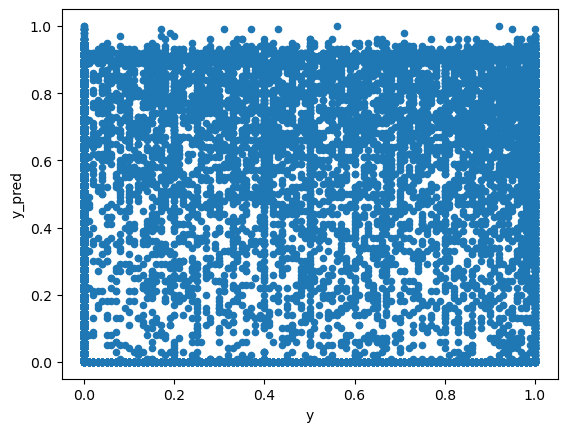

In [14]:
pd.DataFrame([y_test.round(2), pred.round(2)], index = ['y', 'y_pred']).T.plot.scatter(x = 'y', y = 'y_pred')